### Set up

In [2]:
# connect to google drive
import os
import numpy as np

# mount google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# change root directory such that models are saved in google drive during training
root_dir = "/content/gdrive/My Drive/Taiger/Q3"
os.chdir(root_dir)
# print the contents
!ls

email_data.csv	enron_database.json  parrot.pkl
email_data.pkl	enron_email.json     Q3.ipynb


#### Imports 

In [0]:
# export

# basics
import os
import numpy as np

from time import sleep
import requests
from bs4 import BeautifulSoup
import json
from bson import json_util
import time
import re
import datetime
from IPython.core.debugger import set_trace
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

# Spacy
import spacy
nlp = spacy.load('en_core_web_sm')

# clustering
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS # need to install
from sklearn.manifold import TSNE

# sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, decomposition

## Extract Data 

#### Helper functions for extracting emails

In [0]:
# export

def extract_links(url_root, url_sub):
  
  "Function to extract email links for a specific person (url_sub) inside the url_root "
  
  url = url_root + url_sub # get the url of the specific person
  url_res = requests.get(url)
  url_soup = BeautifulSoup(url_res.content,'lxml')
  url_links = url_soup.findAll('a')
  
  clean_links = []
  for link in url_links:
    if link.has_attr('href'):
      clean_link = url + link['href']
      clean_links.append(clean_link)
  
  return clean_links


####
def extract_email(root, email):
  
  """ Given an partial email link and root link, it return an email dict
  with  email title as partial email link and email_link as the complete email link. Removes unnecessary links e.g. '/'
  when len(email) <2. ## Needs to be cleaned ##
  """

  email_dict = {}
  email_title = 'NA'
  #set_trace()
  
  if email.has_attr('href'):
    if (len(email['href'])>=2):

      email_title = str(email['href'])
      email_dict['title'] = email_title
      email_dict['email_link'] = root+email['href']
      
      return email_title, email_dict
  
  return email_title, email_dict


#####
def extract_email_folder(root):
  
  """ Extracts all email links inside a particular directory e.g. 'inbox' of a person 
      
      root: string (e.g. url to inbox of a person)
      Returns a dict object which contains all email links inside the folder 
  """
  
  folder_dict = {} 
  
  folder_res = requests.get(root)
  folder_soup = BeautifulSoup(folder_res.content,'lxml')

  folder_links = folder_soup.findAll('a')
  #set_trace()
  email_id = 0
  
  for email in folder_links:
    
    

    email_title, email_dict = extract_email(root, email)
    if email_title != 'NA':
      
      folder_dict[email_id] = email_dict
      email_id += 1
    
  return folder_dict

In [0]:
# export

### Get email links

#### Get the urls of all emails in the database ######
## The structure of data_root dict is:

## data_root[person_name] = sub_dir
## sub_dir['inbox'] = all_email_links_in_inbox
## all_email_links_in_inbox[counter] = one_email_link
##############


# root url
base_url = 'http://www.enron-mail.com/email/'
url_res = requests.get(base_url) # get html response from the base_url

data_root = {} # initialize with emply dict

if url_res.status_code == 200:
  
  content = url_res.text # html content of root url
  page_soup = BeautifulSoup(content,'lxml')

  page_links = page_soup.findAll('a') # find all anchor tags
  
  for link in page_links: # links to each personal folder
    
    if link.has_attr('href'): # check if anchor tag is valid
      
      # get the name of the person
      try: 
        person_name = link.text[:-1]
      except:
        person_name = str(link['href'])
      
      # extract all folder links e.g. 'inbox' for this person
      personal_links = extract_links(base_url, link['href'])
      
      # contains 'inbox' and 'sent_items' folder 
      sub_dir = {}
      
      for folder in personal_links:
        
        folder_name = folder.split('/')[-2:][0]
        
        #############
        ### Email in the Inbox Folder
        #############
        
        if(folder_name == 'inbox'):
          
          #print('Now extracting {}'.format(person_name))

          folder_dict = extract_email_folder(folder)
          
          
          sub_dir['inbox'] = folder_dict
          
        #############
        # Email in the Sent_items Folder
        #############
        
        if(folder_name == 'sent_items'):
          #print('Now extracting {}'.format(person_name))
          folder_dict = extract_email_folder(folder)
          sub_dir['sent_items'] = folder_dict
        
        
      data_root[person_name] = sub_dir
      ##############

### Save the links

with open('enron_email.json','w') as f:
    json.dump(data_root,f)

In [7]:
## 
print('Estimated number of individuals: {}'.format(len(data_root)))

Estimated number of individuals: 159


### Extract information

In [0]:
# export

## regular expressions

## For email header
to_pat = re.compile(r"To:.+\n")
from_pat = re.compile(r"From:.+\n")
cc_pat = re.compile("Cc:.+\n")
bcc_pat = re.compile(r"Bcc:.+\n")
date_pat = re.compile(r"Date:.+\n")
subject_pat = re.compile("Subject:.+\n")


## to help with extracting emails
char_shift = {'To': 3, 'From':5, 'Cc':3, 'Bcc':4, 'Date':5, 'Subject': 8}

In [0]:
# export

### Find email addresses 
def find_emails(pattern, text, flag=None):
  
  """Returns email addresses based on a pattern e.g. To, From, CC"""
  
  matches = pattern.finditer(text)
  bucket = []
  
  shift = 0
  if flag and flag in char_shift.keys():
    shift = char_shift[flag]
  
  for match in matches:
    start, end = match.span()[0], match.span()[1]
    
    emails = (text[start+shift:end-1]).split(',')
    
    bucket.append(emails)
    
  return bucket
 
### Extracts meta information e.g. subject and date
def find_meta_info(pattern, text, flag=None):
  
  match = pattern.search(text)
  
  shift = 0
  info = None
  
  if flag and flag in char_shift.keys():
    shift = char_shift[flag]
  
  if match:
    start, end = match.span()[0], match.span()[1]
    info = text[start+shift:end-1]
    
    
  return info

## Extract information from email header
def extract_header_info(url_soup):
  
  # Default values
  sender_email = []
  receiver_email = []
  cc_email = []
  bcc_email = []
  sent_date = None
  subject = None
  
  ###
  ### Extracting header information
  
  elements = url_soup.findAll(class_ = 'header')
  
  if len(elements)<1: # nothing found
    
    return sender_email, receiver_email, cc_email, bcc_email, sent_date, subject
  
  
  for element in url_soup.findAll(class_ = 'header'):

    sender_email += find_emails(from_pat,element.text,'From') # sender
    receiver_email += find_emails(to_pat,element.text,'To') # receiver
    cc_email += find_emails(cc_pat,element.text,'Cc') # CC
    bcc_email += find_emails(bcc_pat,element.text,'Bcc') #BCC


    ## Date of email composition
    raw_date = find_meta_info(date_pat,element.text,'Date')


    if raw_date:
      try:
        sent_date = datetime.datetime.strptime(raw_date[:-12], '%a, %d %b %Y %H:%M:%S') # -12 to avoid trailing -0800 (PST) 
      except:
        sent_date = raw_date

    ## Subject of email
    res = find_meta_info(subject_pat,element.text,'Subject')
    if res:
      subject= res
      
    return sender_email, receiver_email, cc_email, bcc_email, sent_date, subject

### Email body

In [0]:
# export

### Extract features from email body using spaCy

def extract_body_features(url_soup):
  
  """ Input: url_soup -> Beautiful soup object of email html page
      Returns: email features e.g.
      all_tokens: words used in email body
      persons: name of the persons mentioned in email body
      ...
  """
  
  email_body = ' '

  for element in url_soup.findAll(class_ = 'ebody'):
    email_body += element.text
  
  doc = nlp(email_body)
  
  all_tokens = []
  persons = []
  locations = []
  cash = []
  # dates ?
  dates = []
  other_NE = []
  
  # all_tokens - stop_words
  all_tokens.append([n.text for n in doc if (not n.is_stop) and (len(n.text)<=15) and (len(n.text)>1)]) # max char in token = 15
  
  ## NER
  for ent in doc.ents:
  
  
    if ent.label_ == 'PERSON':
      persons.append(ent.text)

    elif (ent.label_ == 'GPE') or (ent.label_ == 'LOC'):
      locations.append(ent.text)

    elif ent.label_ == 'MONEY':
      cash.append(ent.text)
      
    elif ent.label_ == 'DATE':
      dates.append(ent.text)
      
    else:
      other_NE.append(ent.text)
      
  return all_tokens[0], persons, locations, cash, dates, other_NE

  

### Create database of all emails with extracted features

In [0]:
# export

## Initialization
email_id =0 
all_emails = []

In [12]:
# export

###
## The email features are extracted in batches
## For example, first batch extracts info from person 1, person 2, .. person 10
## Perform the same such taht all persons are covered

start_time = time.time()


for i, (person_name, box) in enumerate(data_root.items()): # 'allen-p', 'arnold-j', 'arora-h' ...
  
  # extract emails inn batches
  min_batch, max_batch = 0, 6
  
  if (i >= max_batch):
    break
    
  if (i < min_batch):
    continue
    
  print('Now at batch = {}, for {}'.format(i,person_name))
    
  for folder_name, folder_content in box.items(): # 'inbox', 'sent_items'
    for _, email_content in folder_content.items(): # 'ANCHORDESK_2002_in_review_Not_perfect_but_it_sure_.html', ...
      
      email_link = email_content['email_link']

      email = {}
      
      url_res = requests.get(email_link)
      if url_res.status_code != 200:
        break # 404 Not found
        
      url_soup = BeautifulSoup(url_res.content,'lxml')
      
      ## Email Metadata
      sender_email, receiver_email, cc_email, bcc_email, sent_date, subject = extract_header_info(url_soup)
      
      ## Email body
      tokens, persons, locations, cash, dates, other_NE = extract_body_features(url_soup)

      ### Meta attributes
      email['id'] = email_id
      email['folder'] = folder_name
      email['owner'] = person_name
      email['sender'] = sender_email
      email['receiver'] = receiver_email
      email['cc'] = cc_email
      email['bcc'] = bcc_email
      email['date'] = sent_date
      email['subject'] = subject
      
      ### Body attributes
      email['tokens'] = tokens
      email['persons_mentioned'] = persons
      #email['location_mentioned'] = locations
      email['cash'] = cash
      email['dates_mentioned'] = dates
      email['NE'] = other_NE
      
      email_id +=1
      all_emails.append(email)
      
      ## track progress
      if (email_id%100 == 0):
        print('Number of emails processed = {}, in {:.2f} mins'.format(email_id, (time.time() - start_time)/60.0 ))

Now at batch = 0, for Nam
Now at batch = 1, for Last modifie
Now at batch = 2, for Siz
Now at batch = 3, for Descriptio
Now at batch = 4, for Parent Director
Now at batch = 5, for allen-p
Number of emails processed = 100, in 0.20 mins
Number of emails processed = 200, in 0.33 mins
Number of emails processed = 300, in 0.46 mins
Number of emails processed = 400, in 0.63 mins


In [13]:
# print extracted email features

email_item = all_emails[3]

print('\n The extracted features from each email: \n')
for key in email_item.keys():
  print(key)


 The extracted features from each email: 

id
folder
owner
sender
receiver
cc
bcc
date
subject
tokens
persons_mentioned
cash
dates_mentioned
NE


In [0]:
### Save the emails

# with open('enron_database.json','w') as f:
#    json.dump(all_emails,f,default=json_util.default)

### Read in the extracted email database

In [0]:
# export
### Open the emails

with open('enron_database.json','r') as f:
    all_emails = json.load(f)

In [15]:
print('Total number of emails extracted: {}'.format(len(all_emails)))

Total number of emails extracted: 67282


In [0]:
# export

### Create pandas dataframe
email_data = pd.DataFrame(all_emails)

email_data['email_text'] = email_data['tokens'].apply(lambda x: ' '.join(x))
email_data['email_text'] = email_data['email_text'].apply(lambda x: x.lower())

email_data['subject'] = email_data['subject'].fillna('NA')

#apply(lambda x: ' '.join(x))



### Clustering based on subject

In [0]:
# export
## Total number of email
N = len(email_data)

### Features based on email subject

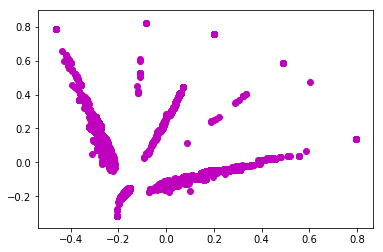

In [93]:
# export

corpus = ' '.join(email_data['subject'])

## Use TF-iDF for extracting email features
tf = TfidfVectorizer(analyzer = 'word', max_df = 0.95, min_df = 5, max_features = 100)

tfidf_matrix = tf.fit_transform(email_data['subject'])

## without SVD
X_email_subject = tfidf_matrix.todense()


# Represent all emails in 2D
coords = PCA(n_components=2).fit_transform(X_email_subject)
plt.scatter(coords[:, 0], coords[:, 1], c = 'm');

### Features based on metadata and cash mentions

In [0]:
# export 

email_data['owner'] = pd.Categorical(email_data['owner']) 
email_data['folder'] = pd.Categorical(email_data['folder']) 
email_data['num_cash'] = email_data['cash'].apply(lambda x: min(len(x), 2)) # number of times $$ is mentioned, capped at 3 mentions

email_data['owner_code'] = email_data['owner'].cat.codes
one_hot_owner = pd.get_dummies(email_data['owner_code'])

email_data['folder_code'] = email_data['folder'].cat.codes

### Combine features
total_features = one_hot_owner.shape[1] + 1 + 1 # one for folder, one for cash
features_mat = np.zeros((N, total_features))
features_mat[:, :one_hot_owner.shape[1]] = one_hot_owner.values


features_mat[:,-1] = email_data['num_cash'].values
features_mat[:,-2] = email_data['folder_code'].values

### Features based on email body

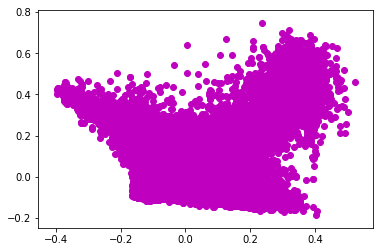

In [95]:
# export
# Let us now create the description corpus
corpus = ' '.join(email_data['email_text'])

## Use TF-iDF for extracting email features
tf = TfidfVectorizer(analyzer = 'word', max_df = 0.95, min_df = 5, max_features = 1000)
tfidf_matrix = tf.fit_transform(email_data['email_text'])

##
X_email_body = tfidf_matrix.todense()


# Represent all emails in 2D
coords = PCA(n_components=2).fit_transform(X_email_body)
plt.scatter(coords[:, 0], coords[:, 1], c = 'm');

In [0]:
# export

### Combine all features
num_feat = X_email_subject.shape[1] + features_mat.shape[1] + X_email_body.shape[1]
X_email = np.zeros((N,num_feat))

X_email[:,:X_email_subject.shape[1]] = X_email_subject
X_email[:,X_email_subject.shape[1]:X_email_subject.shape[1]+ features_mat.shape[1]] = features_mat
X_email[:,X_email_subject.shape[1]+ features_mat.shape[1]:] = X_email_body


In [97]:
X_email.shape

(67282, 1229)

### Clustering

Clustering is an unsupervised operation, and KMeans requires that we specify the number of clusters. One simple approach is to plot the SSE for a range of cluster sizes. We look for the "elbow" where the SSE begins to level off. MiniBatchKMeans introduces some noise so I raised the batch and init sizes higher. Unfortunately the regular Kmeans implementation is too slow. You'll notice different random states will generate different charts. Here I chose 14 clusters.

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


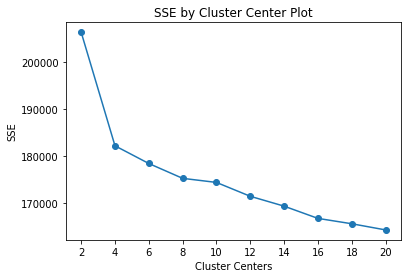

In [101]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X_email, 20)


In [0]:
# export

# n_clusters = 4 (elbow method)
clusters = MiniBatchKMeans(n_clusters=4, init_size=1024, batch_size=2048, random_state=20).fit_predict(X_email)

In [0]:
#clusters_kmeans = KMeans(n_clusters=8, max_iter=100, init='k-means++', n_init=1).fit_predict(X_email)

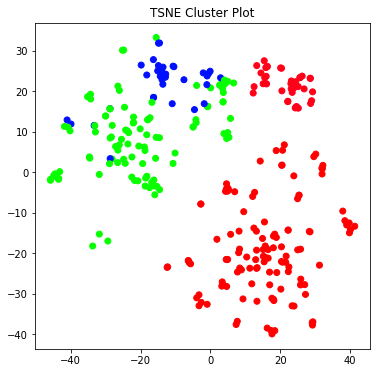

In [103]:
# export

def plot_tsne_pca(data, labels):
    
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=1000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:])
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:]))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    # ax[0].set_title('PCA Cluster Plot')
    
    ax.scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax.set_title('TSNE Cluster Plot')
    
plot_tsne_pca(X_email, clusters)

Cluster 0


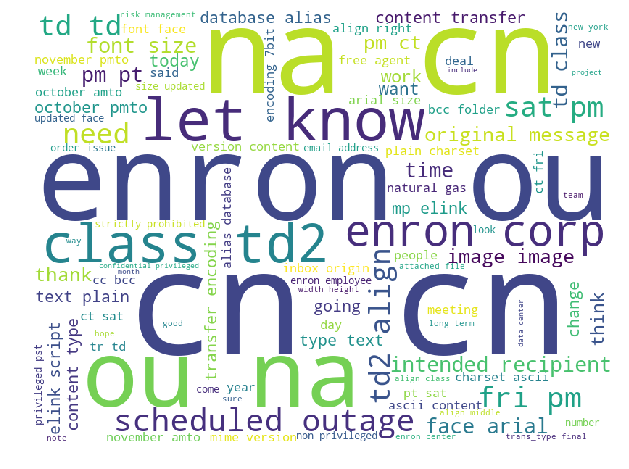

Cluster 1


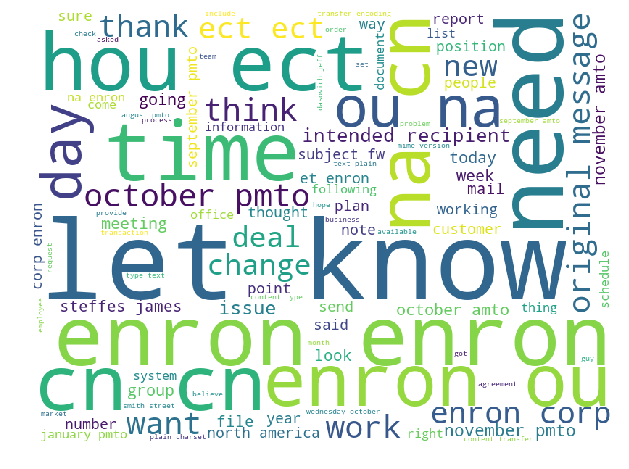

Cluster 2


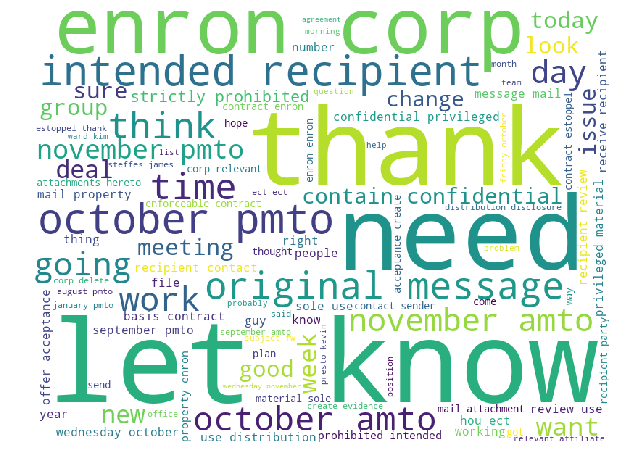

Cluster 3


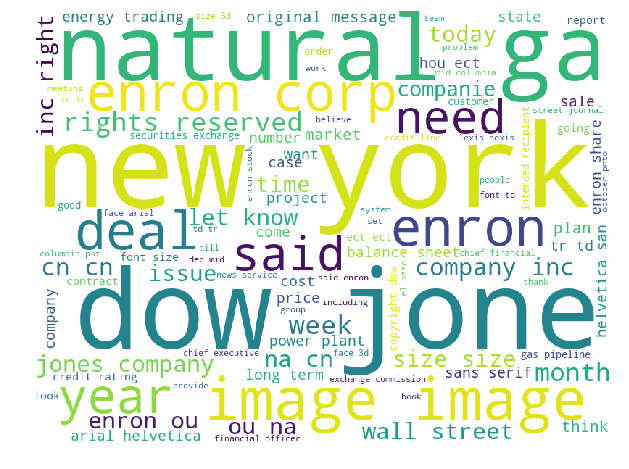

In [105]:
# export

df_clusters = pd.DataFrame(email_data).groupby(clusters)

stop_words = ["monday", "sent", "tuesday", "thursday", "recipients"] + list(STOPWORDS)

for name, group in df_clusters:
  
  corpus = ' '.join(group['email_text'])
  print('='*50)
  print('Cluster {}'.format(name))
  ## Plot
  df_wordcloud = WordCloud(stopwords = stop_words, background_color = 'white', height = 600, width = 800, max_words=100).generate(corpus)
  plt.figure(figsize = (16,8))
  plt.imshow(df_wordcloud)
  plt.axis('off')
  plt.show()

In [0]:
### Clustering Just based on email body??